In [1]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold






In [2]:
matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  # shuffle
# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)

X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 
                       'Site','CT','MRI','ICD_I62.0', 'ICD_S06.5', 'ICD_432.1', 'ICD_852.2or3'], axis=1) 
print(X)

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1451      116551953  2017-04-12   
1           1625      150626794  2016-06-28   
2            921      111708750  2020-07-01   
3           2827      150293166  2013-11-24   
4           2675      150744963  2011-09-26   
...          ...            ...         ...   
1494        1806      150001850  2014-07-26   
1495        1048      115875112  2016-11-04   
1496        1406      115098587  2021-07-12   
1497         927      117157833  2021-03-29   
1498        1731      151195673  2015-04-27   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13364499668_1918544682_20170412.txt    MGB   1    1             0   
1      Notes_1130485717_9766596953_20160628.txt  BIDMC   1    0             0   
2     Notes_13504793443_3523347700_20200701.txt    MGB   0    0             0   
3       Notes_1130151802_169903067_20131124.txt  BIDMC   0    0             0   
4      Notes_1130603513_143940

In [3]:
# Initialize variables for storing results
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}

# Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

for cvi, (train_index, test_index) in enumerate(gkf.split(X, y, groups=y_data_pre['BDSPPatientID'])):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]
        
    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())


    model = RandomForestClassifier(
        n_estimators=100,
        random_state=2023,
        n_jobs=-1
    )
    
    search_spaces = {
        'n_estimators': (50, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
    }
    
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50,
        scoring='roc_auc',
        n_jobs=47,
        cv=10,
        random_state=2023
    )
    
    model_cv.fit(Xtr, ytr)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:, 1]
    yte_pred = model.predict_proba(Xte)[:, 1]

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)

    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    model_filename = f'keywords_only_RF_model_train_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)


    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    feature_importances = model.feature_importances_
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('RF_keywords_only_fold_patient_ids_.csv', index=False)

Feature importances for this fold:
             Feature  Importance
22           sdh_pos    0.362264
19  neurosurgeri_pos    0.167372
23        subdur_pos    0.117168
7        ct head_pos    0.050429
10       head ct_pos    0.047119
..               ...         ...
34     brain mri_neg    0.000000
33  brain injuri_neg    0.000000
31     known sdh_pos    0.000000
30    resolv sdh_pos    0.000000
32      acut sdh_neg    0.000000

[65 rows x 2 columns]
[0.9785029785029785]
[0.9207870210190044]
Feature importances for this fold:
             Feature  Importance
22           sdh_pos    0.360995
19  neurosurgeri_pos    0.167010
23        subdur_pos    0.100680
7        ct head_pos    0.048516
16  midlin shift_pos    0.046949
..               ...         ...
35     burr hole_neg    0.000000
44   chronic sdh_neg    0.000000
36     stabl sdh_neg    0.000000
41         evacu_neg    0.000000
32      acut sdh_neg    0.000000

[65 rows x 2 columns]
[0.9785029785029785, 0.9755244755244755]
[0.920787

In [4]:
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))


0.9755226495686316
0.8719565135843341


/tmp/ipykernel_19650/2281044350.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'acut sdh_pos' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_importance_df.loc[i, 'Feature'] = feature


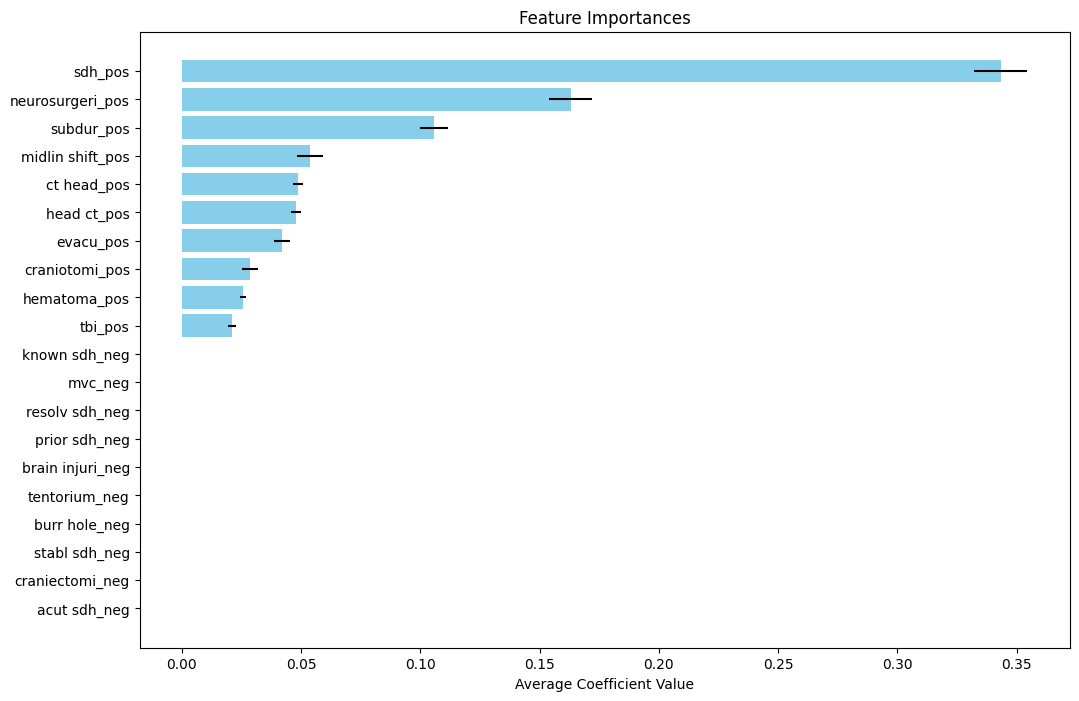

<Figure size 640x480 with 0 Axes>

In [5]:
# Aggregate feature importances by averaging over folds
feature_importance_df = pd.DataFrame(data={'Feature':[], 'Importance':[], 'Importance_se':[]})

for i, (feature, importances) in enumerate(feature_importances_dict.items()):
    feature_importance_df.loc[i, 'Feature'] = feature
    feature_importance_df.loc[i, 'Importance'] = np.mean(importances)
    feature_importance_df.loc[i, 'Importance_se'] = np.std(importances)/np.sqrt(len(importances))

feature_importance_df = feature_importance_df.sort_values('Importance', axis=0, ignore_index=True, ascending=False)

feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/keywords_feat_importances_both_hospitals_.csv', index=False)#

# Select top 10 and bottom 10 features
top_features = feature_importance_df.Feature.iloc[:10]
top_importances = feature_importance_df.Importance.iloc[:10]
top_importances_se = feature_importance_df.Importance_se.iloc[:10]
bottom_features = feature_importance_df.Feature.iloc[-10:]
bottom_importances = feature_importance_df.Importance.iloc[-10:]
bottom_importances_se = feature_importance_df.Importance_se.iloc[-10:]

# Combine top and bottom features for plotting
plot_features = pd.concat([top_features, bottom_features])
plot_importances = pd.concat([top_importances, bottom_importances])
plot_importances_se = pd.concat([top_importances_se, bottom_importances_se])

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue', xerr=2*plot_importances_se) 
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/keywords_feat_importances_both_hospitals_.png')#

In [6]:
# # before running this check for keywords
# # Define custom feature names
# custom_plot_features = [
#     "sdh positive", "neurosurgery positive", "ICD code S06.5", "subdural positive", "ICD code 432.1", "midline shift positive", 
#     "head ct positive", "hematoma positive", "ct head positive","ICD code 162.0",
#     "thickness negative", "acute sdh negative", "burr hole surgery negative", "craniectomy negative", "chronic sdh negative",
#     "intraparenchymal hemorrhage negative", "motor vehicle accident negative", "motor vehicle crash negative", "tbi negative",
#     "tentorium negative"
# ]

# # Ensure the length of custom features matches the length of plot_features
# assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."

# # Plot feature importances
# plt.figure(figsize=(12, 8))
# bars = plt.barh(range(len(plot_features)), plot_importances, color='skyblue')
# plt.xlabel('Average Coefficient Value')
# plt.title('Feature Importances')
# plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# # Set custom y-axis labels
# plt.yticks(range(len(plot_features)), custom_plot_features)

# # Display the plot
# plt.show()


In [7]:
cf_cv

[array([[107,  10],
        [  1,  32]]),
 array([[110,   7],
        [  2,  31]]),
 array([[101,   7],
        [  0,  42]]),
 array([[112,  12],
        [  0,  26]]),
 array([[109,  11],
        [  1,  29]]),
 array([[111,  13],
        [  0,  26]]),
 array([[102,   8],
        [  1,  39]]),
 array([[108,   4],
        [  4,  34]]),
 array([[100,  11],
        [  4,  35]]),
 array([[99, 12],
        [ 1, 37]])]

In [8]:

# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)

Overall Confusion Matrix:
 [[1059   95]
 [  14  331]]


In [9]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.9267
Precision: 0.7619
Recall: 0.9697
F1 Score: 0.8533

Metrics for Fold 2:
Accuracy: 0.9400
Precision: 0.8158
Recall: 0.9394
F1 Score: 0.8732

Metrics for Fold 3:
Accuracy: 0.9533
Precision: 0.8571
Recall: 1.0000
F1 Score: 0.9231

Metrics for Fold 4:
Accuracy: 0.9200
Precision: 0.6842
Recall: 1.0000
F1 Score: 0.8125

Metrics for Fold 5:
Accuracy: 0.9200
Precision: 0.7250
Recall: 0.9667
F1 Score: 0.8286

Metrics for Fold 6:
Accuracy: 0.9133
Precision: 0.6667
Recall: 1.0000
F1 Score: 0.8000

Metrics for Fold 7:
Accuracy: 0.9400
Precision: 0.8298
Recall: 0.9750
F1 Score: 0.8966

Metrics for Fold 8:
Accuracy: 0.9467
Precision: 0.8947
Recall: 0.8947
F1 Score: 0.8947

Metrics for Fold 9:
Accuracy: 0.9000
Precision: 0.7609
Recall: 0.8974
F1 Score: 0.8235

Metrics for Fold 10:
Accuracy: 0.9128
Precision: 0.7551
Recall: 0.9737
F1 Score: 0.8506

Overall Metrics:
Accuracy: 0.9273
Precision: 0.7770
Recall: 0.9594
F1 Score: 0.8586


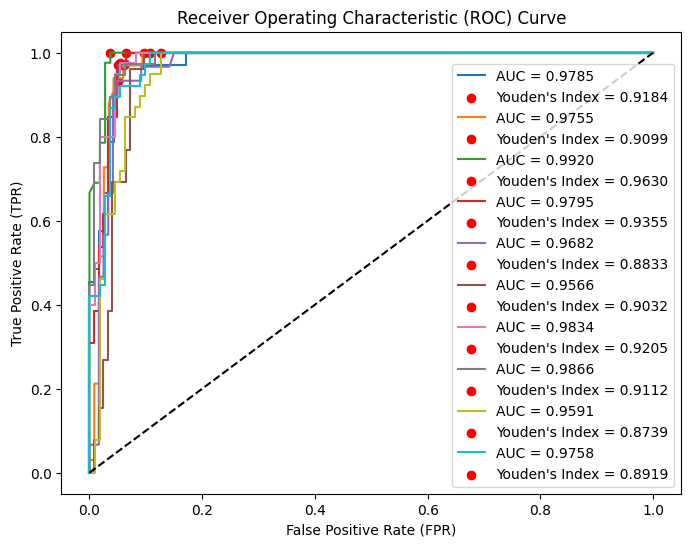

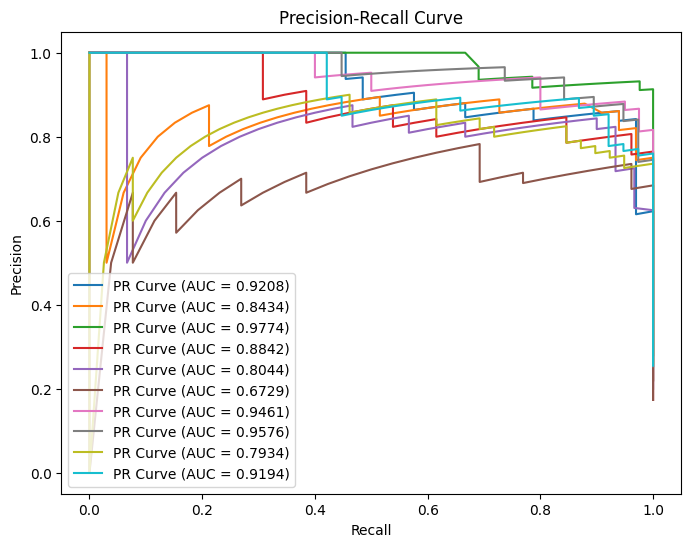

0.9755226495686316
0.8556113812252981


In [10]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('keywords_Only_RF_both_hospitals_AUC_iter_.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('keywords_Only_RF_both_hospitals_PR_iter_.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('keywords_Only_RF_LR_iter_pred_rr_both_hospitals_.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv('keywords_Only_RF_LR_iter_both_hospitals_.csv')

# Print final Data
print(auc_final)
print(f1_final)

In [2]:
###Testing the ICD_only


import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

In [3]:
# load testing set

#Detecting ACTIVE SDH not just sdh. Pretty great results. 

matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  # shuffle
# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y_holdout = y_data_pre['annot']
print(y_holdout)

X_data=X_data.drop(['annot'], axis=1)
X_holdout=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 
                       'Site','CT','MRI','ICD_I62.0', 'ICD_S06.5', 'ICD_432.1', 'ICD_852.2or3'], axis=1) 
print(X_holdout)
feature_names = X_holdout.columns.tolist()

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1451      116551953  2017-04-12   
1           1625      150626794  2016-06-28   
2            921      111708750  2020-07-01   
3           2827      150293166  2013-11-24   
4           2675      150744963  2011-09-26   
...          ...            ...         ...   
1494        1806      150001850  2014-07-26   
1495        1048      115875112  2016-11-04   
1496        1406      115098587  2021-07-12   
1497         927      117157833  2021-03-29   
1498        1731      151195673  2015-04-27   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13364499668_1918544682_20170412.txt    MGB   1    1             0   
1      Notes_1130485717_9766596953_20160628.txt  BIDMC   1    0             0   
2     Notes_13504793443_3523347700_20200701.txt    MGB   0    0             0   
3       Notes_1130151802_169903067_20131124.txt  BIDMC   0    0             0   
4      Notes_1130603513_143940

Accuracy: 0.9446 (95% CI: 0.9340 - 0.9566)
Precision: 0.8211 (95% CI: 0.8115 - 0.8846)
Recall (Sensitivity): 0.9710 (95% CI: 0.9033 - 0.9588)
F1 Score: 0.8898
AUC (ROC): 0.9853 (95% CI: 0.9805 - 0.9895)
AUC (PR): 0.9444 (95% CI: 0.9229 - 0.9621)
Specificity: 0.9367
False Positives: 73
False Negatives: 10


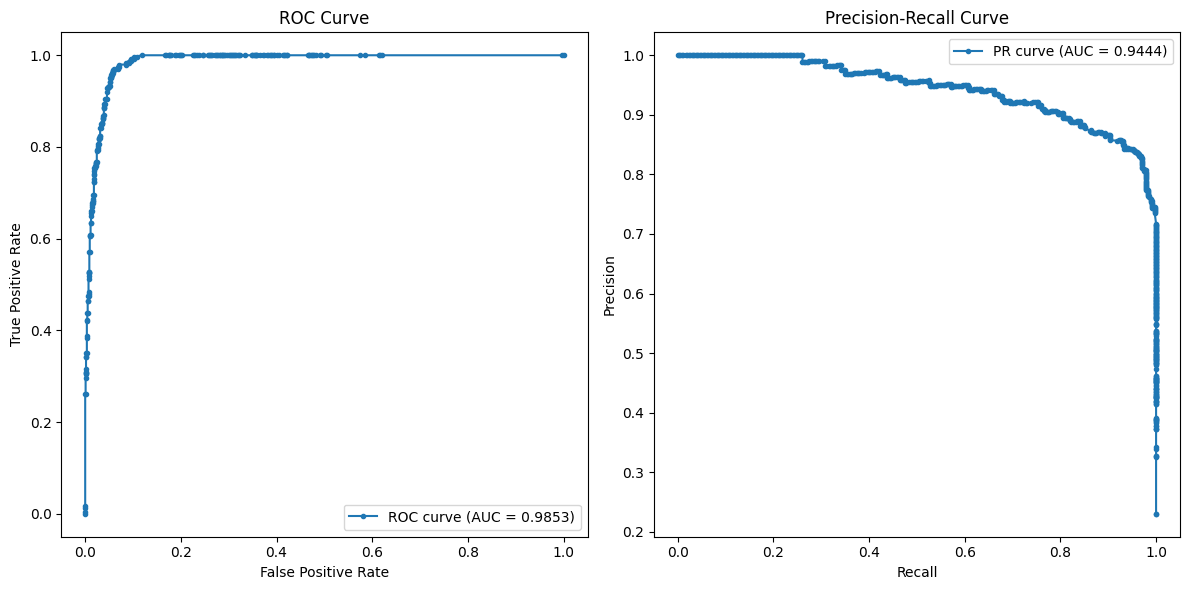

Number of False Positive Patient IDs: 73
Number of False Negative Patient IDs: 10


In [4]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_curve, auc, confusion_matrix, accuracy_score
)
from sklearn.utils import resample

# Function to compute confidence intervals using bootstrapping
def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
    stats = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        stat = metric_func(y_true_bs, y_pred_proba_bs)
        stats.append(stat)
    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Load models and cutoffs
models = []
cutoffs = []
feature_importances_dict = {}

for fold in range(10):
    with open(f'keywords_only_RF_model_train_fold{fold+1}.pickle', 'rb') as f:
        res = pickle.load(f)
    models.append(res['model'])
    cutoffs.append(res['cutoff'])
    feature_importances_dict[fold] = res['model'].feature_importances_

# Predict on holdout set
y_pred_proba = np.zeros(X_holdout.shape[0])
y_pred = np.zeros(X_holdout.shape[0])

for model, cutoff in zip(models, cutoffs):
    yp_proba = model.predict_proba(X_holdout)[:, 1]
    y_pred_proba += yp_proba
    y_pred += (yp_proba > cutoff).astype(int)

# Average probability and majority vote
y_pred_proba /= len(models)
y_pred = (y_pred > (len(models) / 2)).astype(int)

# Calculate metrics
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
accuracy = accuracy_score(y_holdout, y_pred)
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Compute confidence intervals
accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

# Print metrics
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f}")
print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.', label=f'PR curve (AUC = {auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Extract patient IDs for false positives and false negatives
# Ensure that the index of the DataFrame is properly aligned
# Assuming matrix.BDSPPatientID is a pandas Series with correct alignment
false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]

# Create DataFrames with patient IDs, annot (y_holdout), and y_pred
false_positive_df = pd.DataFrame({
    'BDSPPatientID': false_positive_ids,
    'annot': y_holdout[(y_holdout == 0) & (y_pred == 1)],
    'y_pred': y_pred[(y_holdout == 0) & (y_pred == 1)]
})

false_negative_df = pd.DataFrame({
    'BDSPPatientID': false_negative_ids,
    'annot': y_holdout[(y_holdout == 1) & (y_pred == 0)],
    'y_pred': y_pred[(y_holdout == 1) & (y_pred == 0)]
})

# Print the number of false positive and false negative patient IDs
print(f"Number of False Positive Patient IDs: {len(false_positive_df)}")
print(f"Number of False Negative Patient IDs: {len(false_negative_df)}")

# Save to CSV files
false_positive_df.to_csv("false_positive_ids_best_model.csv", index=False)
false_negative_df.to_csv("false_negative_ids_best_model.csv", index=False)


Metrics on Holdout Set:
AUC_Roc: 0.9853 (95% CI: 0.9807 - 0.9895)
F1 Score: 0.8898 (95% CI: 0.8654 - 0.9129)
Precision: 0.8211 (95% CI: 0.7820 - 0.8591)
Recall: 0.9710 (95% CI: 0.9509 - 0.9867)
Accuracy: 0.9446 (95% CI: 0.9333 - 0.9560)
Specificity: 0.9367 (95% CI: 0.9219 - 0.9507)
AUC_PR: 0.9444 (95% CI: 0.9240 - 0.9620)


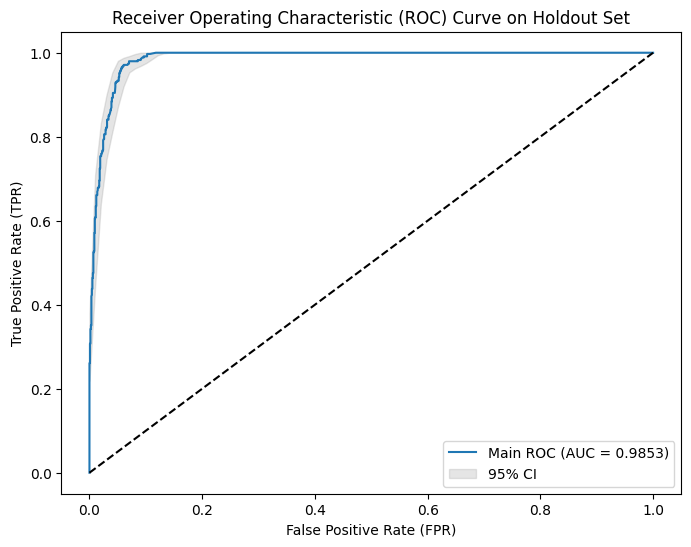

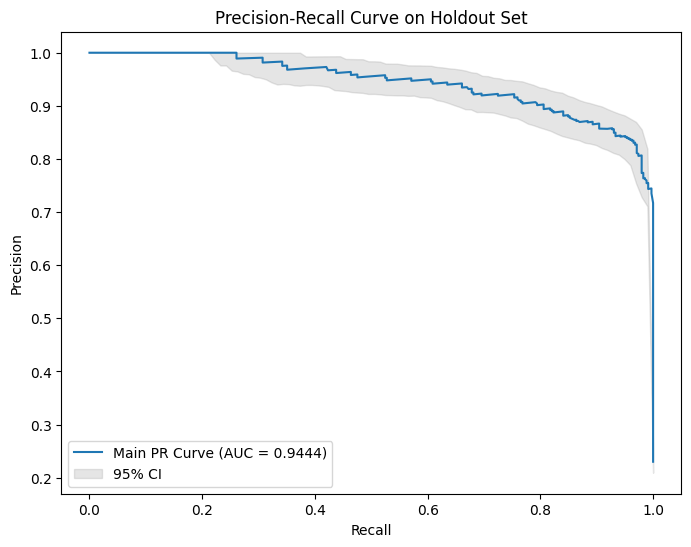

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    specificities = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        y_true_resampled = y_true[indices]
        y_pred_proba_resampled = y_pred_proba[indices]
        y_pred_resampled = y_pred[indices]

        # Calculate metrics
        aucs.append(roc_auc_score(y_true_resampled, y_pred_proba_resampled))
        f1s.append(f1_score(y_true_resampled, y_pred_resampled))
        precisions.append(precision_score(y_true_resampled, y_pred_resampled))
        recalls.append(recall_score(y_true_resampled, y_pred_resampled))
        accuracies.append(accuracy_score(y_true_resampled, y_pred_resampled))
        
        # Compute specificity
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
        
        # Compute AUC-PR
        precision, recall, _ = precision_recall_curve(y_true_resampled, y_pred_proba_resampled)
        auc_prs.append(auc(recall, precision))
        
        # Compute ROC and PR curves
        fpr, tpr, _ = roc_curve(y_true_resampled, y_pred_proba_resampled)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    specificity_ci = np.percentile(specificities, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves, pr_curves

# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_holdout, y_pred_proba, y_pred)

# Calculate metrics on holdout set
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
accuracy = accuracy_score(y_holdout, y_pred)
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel()
specificity_holdout = tn / (tn + fp) if (tn + fp) > 0 else 0
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)

# Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC_Roc: {auc_roc:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Specificity: {specificity_holdout:.4f} (95% CI: {specificity_ci[0]:.4f} - {specificity_ci[1]:.4f})")
print(f"AUC_PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

# Plot ROC curve with confidence intervals
plt.figure(figsize=(8, 6))
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)
plt.plot(main_fpr, main_tpr, label=f'Main ROC (AUC = {main_auc:.4f})')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Holdout Set')
plt.legend(loc='lower right')
plt.savefig('kw_AUC_holdout.png')
plt.show()

# Plot PR curve with confidence intervals
plt.figure(figsize=(8, 6))
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)
plt.plot(main_recall, main_precision, label=f'Main PR Curve (AUC = {main_auc_pr:.4f})')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2, label='95% CI')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Holdout Set')
plt.legend(loc='lower left')
plt.savefig('kw_PR_holdout.png')
plt.show()

# Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'specificity', 'auc_pr'],
    'value': [auc_roc, f1_holdout, precision_holdout, recall_holdout, accuracy, specificity_holdout, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], specificity_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], specificity_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('kw_RC_CI_holdout_metrics.csv', index = False)


Confusion Matrix:
[[1081   73]
 [  10  335]]
True Negatives (TN): 1081
False Positives (FP): 73
False Negatives (FN): 10
True Positives (TP): 335
Specificity: 0.9367
False Positives: 73
False Negatives: 10


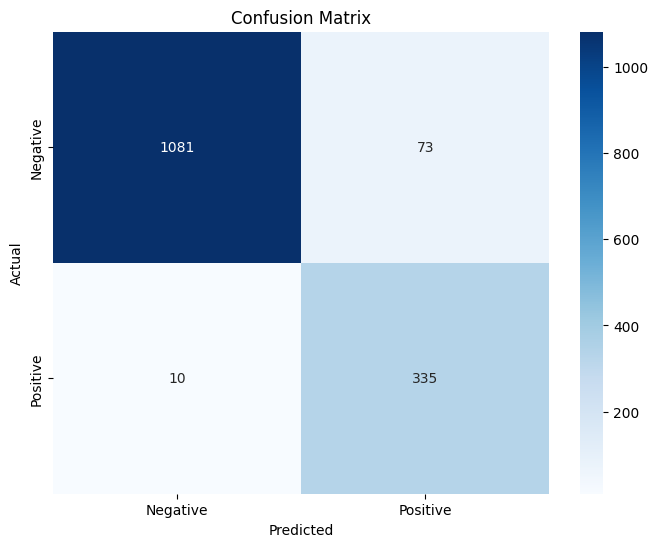

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix. #y_holdout = actual annotations. y_pred = predicted annotations. 
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(cf_holdout)
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_holdout, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


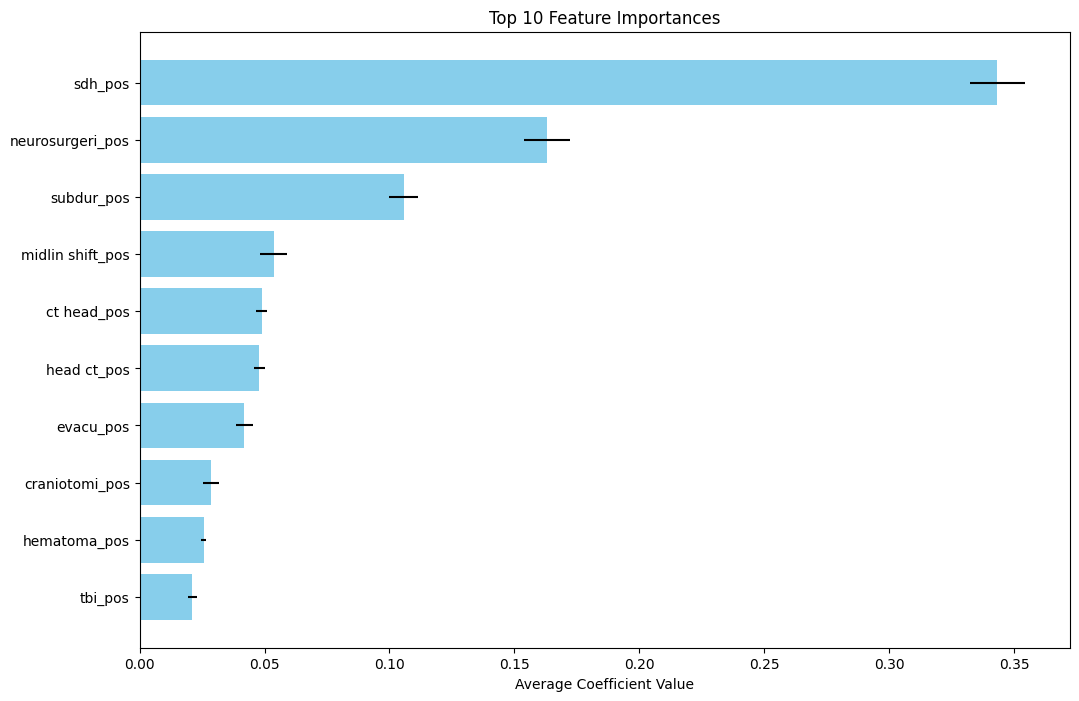

In [7]:
# Compute feature importances
all_feature_importances = np.array([importance for importance in feature_importances_dict.values()])
average_feature_importances = np.mean(all_feature_importances, axis=0)
std_feature_importances = np.std(all_feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Assuming feature_names is defined elsewhere
    'Importance': average_feature_importances,
    'Importance_se': std_feature_importances / np.sqrt(len(models))
})

# Sort and select top 10 features
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False, ignore_index=True)
top_features = feature_importance_df.head(10)
bottom_features = feature_importance_df.tail(10)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue', xerr=2*top_features['Importance_se']) 
plt.xlabel('Average Coefficient Value')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Save feature importances to CSV
feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/kw_feature_importances_test.csv', index=False)
